# Simulation for Penalized Potts model
- All levels of interaction
- Field (constant for each point)
- Preference for low number of colors
- Distance between different colors (0 if equal, 1 of different)

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- Consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$ (a set with $k$ colors corresponds to $k$).
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$


- Consider the interaction between adjacent sites (edges) $b$ with size $|b|=2$
- To each edge assign $\eta_{b} \in \mathcal{P}(\{0,1\}^2)$ which is in one-to-one correspondence with the edge being open or closed.
- Each of these corresponds to an energy level in $\{J, -J\}$

- Consider the interaction between adjacent sites and the field, corresponding to $v$ with size $|v|=1$
- To each site assign $\eta_{v} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with the color of the site.
- Each of these corresponds to an energy level in $\{(N-1)\alpha, (N-2)\alpha, ...,(N-k)\alpha, ...,0\}$ where $k$ corresponds to the $k$th preferred color of the field.

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [1]:
import numpy as np 
from numpy.random import rand
from scipy.special import binom
from unionfind import UnionFind
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Stirling numbers of second kind
S = [[0 for i in range(1001)] for j in range(1001)]

# Combinations
C = [[0 for i in range(1001)] for j in range(1001)]

def stirling(n,k,S):
    if S[n][k] > 0: return S[n][k]
    if k>n or k==0 or n==0: return 0
    if k==1 or k==n:
        S[n][k]=1
    else:
        S[n][k] = stirling(n-1,k-1,S) + k*stirling(n-1,k,S)
    return S[n][k]

def P_exact_cols(n,k,cl,S):
    p = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        p*=i
    p = p*stirling(cl,k,S)
    return p

def combs(n,k,C,S):
    if C[n][k] > 0: return C[n][k]
    if k>n or k==0 or n==0: return 0
    c = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        c*=i
    C[n][k] = c*stirling(n,k,S)
    return C[n][k]

def H(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors
def H_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += k * C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors squared
def H_t_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += (k**2) * C[n][k] * (z**k)
    return h

def E_cols(n,z,C):
    return H_t(n,z,C)/H(n,z,C)

def Var_cols(n,z,C):
    EX_2 = H_t_t(n,z,C)/H(n,z,C)
    v = EX_2 - (E_cols(n,z,C)**2)
    # if v < 0: print("Negative variance in",n,z,C)
    return v

def std_cols(n,z,C):
    return Var_cols(n,z,C)**(0.5)

In [3]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

session = WolframLanguageSession()

for i in range(1001):
    if i%100==0: print(i)
    for j in range(1001):
        stirling(i,j,S)
        combs(i,j,C,S)
        
bell_dict = {}

0
100
200
300
400
500
600
700
800
900
1000


## Main Implementation

In [4]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/
# Implement Union Find to find clusters in the configurations
# https://github.com/deehzee/unionfind/blob/master/unionfind.py

# Toggle printing for debugging
prt = True

def initial_config(N, no_colors=2, init_type="Noise"):   
    ''' Generate a random color/spin configuration for initialization'''
    if init_type=="Noise":
        return np.random.randint(low=1, high=no_colors+1, size=(N,N))
    elif init_type=="Uniform":
        color = np.random.randint(low=1, high=no_colors+1)
        return np.full((N, N), color)
    return state


def mc_move(config, eta_prob, eta, N, no_colors, sites, param_name, curr_params):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, eta, no_colors)
    # Assign labels to each site
    config = assign_labels(config, eta, N, no_colors, sites, param_name, curr_params)
    if prt: print('config:')
    if prt: print(config)
    return config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def prob_eta_lambda(gamma, no_colors, k):
    '''Probability of the eta lambda corresponding to a certain number of colors'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*gamma) - np.exp((no_colors-k-1)*gamma) ) / np.exp((no_colors-1)*gamma)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*gamma)
    
    
def prob_eta_edge(J, col1, col2):
    '''Probability of the eta edge corresponding to open or not'''
    if col1==col2:
        return 1 - np.exp(-2*J)
    else:
        return np.exp(-2*J)
    
    
def prob_eta_site(alpha, no_colors, k):
    '''Probability of the eta site corresponding to a maximum color number (lower have higher energy)'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*alpha) - np.exp((no_colors-k-1)*alpha) ) / np.exp((no_colors-1)*alpha)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*alpha)

    
def assign_etas(config, eta_prob, eta, no_colors):
    
    '''Assign a number of colors that is at least the current number of colors'''
    eta_lambda = eta[0]
    prob_lambda = eta_prob[0]
    if prt: print('probabilities for no. of colors (lambda):', prob_lambda)
    
    current_k = number_of_colors(config)
    if prt: print('current no. cols (lambda):', current_k)
    p = prob_lambda[current_k-1:]
    p = p / p.sum()
    eta_lambda = np.random.choice((np.arange(current_k, no_colors+1)), p=p)
    eta[0] = eta_lambda
    if prt: print('assigned no. cols (eta_lambda):', eta_lambda)

    '''Assign a closed or open bond to each edge'''
    eta_edges = eta[1]
    prob_edge = eta_prob[1]
    if prt: print('probabilities for edges:', prob_edge)
    
    # loop over edges
    for i in range(eta_edges.shape[0]):
        for j in range(eta_edges.shape[1]):
            for e in range(eta_edges.shape[2]):
                if eta_edges[i,j,e] == -1: continue
                if e==0: current_b = (0 if config[i,j]==config[i+1,j] else 1)          
                elif e==1: current_b = (0 if config[i,j]==config[i,j+1] else 1)      
                p = prob_edge[current_b:]
                p = p / p.sum()
                eta_edge = np.random.choice((np.arange(current_b, 1+1)), p=p) # 0 for present bonds, 1 for not
                eta_edges[i,j,e] = eta_edge
    eta[1] = eta_edges
    if prt: print('assigned bonds (eta_edges):')
    if prt: print(eta_edges[:,:,0])
    if prt: print()
    if prt: print(eta_edges[:,:,1])
    
    '''Assign a color that has at most the current energy for the color (color number is at least the current one)'''
    eta_sites = eta[2]
    prob_site = eta_prob[2]
    if prt: print('probabilities for colors (sites):', prob_site)
    
    # loop over sites
    for i in range(eta_sites.shape[0]):
        for j in range(eta_sites.shape[1]):
            current_s = config[i,j]
            p = prob_site[current_s-1:]
            p = p / p.sum()
            eta_site = np.random.choice((np.arange(current_s, no_colors+1)), p=p)
            eta_sites[i,j] = eta_site
    eta[2] = eta_sites
    if prt: print('assigned max colors (eta_sites):')
    if prt: print(eta_sites)
    
    return eta


def site2str(tup):
    return str(tup[0]) + ',' + str(tup[1])

def str2site(strr):
    t = strr.split(',')
    return [int(x) for x in t]


def brute_force_sample (cluster_constraints, cls, uf, config):
    '''Randomly sample a color for each cluster'''
    max_col = None
    for cluster in uf.components():
        for site_str in cluster:
            site = str2site(site_str)
            max_col = cluster_constraints[cls[site[0],site[1]]]
            cluster_color = np.random.choice((np.arange(1, max_col+1)))
            break
        for site_str in cluster:
            site = str2site(site_str)
            config[site[0],site[1]] = cluster_color
    if prt: print("done sampling cluster colors")
    
    return config


def sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf=None, cluster_constraints=None):
    
    if uf==None and not only_averages:
        '''Generate clusters from the assigned bonds (eta_edge)'''
        uf = UnionFind(sites)
        eta_edges = eta[1]
        for i in range(eta_edges.shape[0]):
            for j in range(eta_edges.shape[1]):
                for e in range(eta_edges.shape[2]):
                    if eta_edges[i,j,e] == -1: continue
                    if eta_edges[i,j,e] == 0:
                        if e==0: uf.union(site2str((i,j)), site2str((i+1,j)))
                        elif e==1: uf.union(site2str((i,j)), site2str((i,j+1)))    

        '''For each cluster, find the site with strongest constraint (smallest eta_site)
           and assign that eta_site to the entire cluster
        '''
        eta_sites = eta[2]
        cluster_constraints = {}
        cl_n = 0
        cls = np.zeros((eta_sites.shape[0],eta_sites.shape[1]), dtype=np.uint16) # up to 255x255 box
        for cluster in uf.components():
            cl_n += 1
            min_constraint = no_colors
            cluster_root = '-1,-1'
            for site_str in cluster:
                site = str2site(site_str)
                if eta_sites[site[0],site[1]] <= min_constraint:
                    min_constraint = eta_sites[site[0],site[1]]
                    cluster_root = site_str
                cls[site[0],site[1]] = cl_n
            cluster_constraints[cluster_root] = min_constraint
            cluster_constraints[cl_n] = min_constraint
        if prt: print('clusters formed by bonds (eta_edge):')
        if prt: print(cls)
    
    # Case with no field and gamma > 0
    if (curr_params['alpha']==0 and curr_params['gamma']>0):
        if prt: print('Case with no field and gamma > 0')
            
        '''Choose exactly how many colors to use in the configuration'''
        max_colors = eta[0] # eta_lambda
        prob_k = []
        if only_averages:
            no_cl = N*N
        else:
            no_cl = len(uf.components())
        for k in range(1,max_colors+1):
            prob_k.append(P_exact_cols(no_colors,k,no_cl,S))
        if prt: print('prob_k:', prob_k)
        prob_k = [pk / sum(prob_k) for pk in prob_k]
        prob_k = np.array(prob_k)
        if prt: print('prob_k:', prob_k)
        exact_k = np.random.choice((np.arange(1, max_colors+1)), p=prob_k)
        if prt: print('exact number of colors to use in configuration:')
        if prt: print(exact_k)
            
        if only_averages:
            '''Only compute average in case with zero field and no interaction, but with gamma > 0,
               use an arbitray partition (avoid computing Bell polynomials)
            '''
            chosen_colors = range(1,exact_k+1)
            if exact_k == no_colors:
                chosen_partition = [exact_k]
            else:
                chosen_partition = [exact_k-1] + [0]*max(0,no_colors-exact_k-1) + [1]
            part = []
            for i in range(len(chosen_partition)):
                part += ([i+1]*chosen_partition[i])
            chosen_partition = part
            if prt: print('chosen partition:')
            if prt: print(chosen_partition)
            color_arr = []
            for i in range(len(chosen_partition)):
                color_arr += [chosen_colors[i]]*chosen_partition[i]
            config = np.array(color_arr).reshape((N,N))
            return config, None, None

        '''Sample a partition of the no. of clusters into k blocks using Bell polynomials'''
        partition_dict = {}
        if ((no_cl,exact_k) in bell_dict):
            partition_dict = bell_dict[(no_cl,exact_k)]
            if prt: print ("Bell found", (no_cl,exact_k))
        else:
            session.evaluate("subs = Array[x,"+str(no_cl-exact_k+1)+"]")
            partition_dict = session.evaluate("Association@CoefficientRules[BellY["+str(no_cl)+", "+str(exact_k)+", subs], subs]")
            bell_dict[(no_cl,exact_k)] = partition_dict
            if prt: print ("Bell computed", (no_cl,exact_k))
        if prt: print("partition_dict", partition_dict)
        partitions = []
        partition_p = []
        for partition in partition_dict:
            partitions.append(partition)
            partition_p.append(partition_dict[partition])
        if prt: print('partition_p:', partition_p)
        partition_p = [pk / sum(partition_p) for pk in partition_p]
        parition_p = np.array(partition_p)
        if prt: print('partition_p:', partition_p)
        chosen_partition = partitions[np.random.choice((np.arange(0, len(partitions))), p=partition_p)]
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)
        # Transform to actual partition
        part = []
        for i in range(len(chosen_partition)):
            part += ([i+1]*chosen_partition[i])
        chosen_partition = part
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)

        '''Color each block in the partition randomly without replacement'''
        # Choose the colors to be used
        chosen_colors = np.random.choice((np.arange(1, no_colors+1)), len(chosen_partition), replace=False)
        # Choose a random permutation of the given word
        color_arr = []
        for i in range(len(chosen_partition)):
            color_arr += [chosen_colors[i]]*chosen_partition[i]
        color_arr = np.array(color_arr)
        color_arr = np.random.permutation(color_arr)
        if prt: print('colors for clusters:')
        if prt: print(color_arr)
        
        '''Color each cluster with the assigned color'''
        i=0
        for cluster in uf.components():
            cluster_color = color_arr[i]
            for site_str in cluster:
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            i+=1
    
    # Case with field and gamma > 0 or case with gamma = 0
    else:
        '''Randomly sample a color for each cluster'''
        if prt: print('Case with field and gamma > 0 or case with gamma = 0')
        config = brute_force_sample (cluster_constraints, cls, uf, config)
            
    return config, uf, cluster_constraints


def assign_labels(config, eta, N, no_colors, sites, param_name, curr_params):
    '''Assign a color configuration chosen uniformly from the configurations compatible with eta'''
    # Brute force until compatible with eta_lambda
    max_colors = eta[0] # eta_lambda
    config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, param_name, curr_params)
    while number_of_colors(config) > max_colors:
        config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf, cluster_constraints)
        if prt: print('retrying sample (too many colors)')
    return config

## Experiment routine

In [5]:
def single_experiment (N, no_cols, gamma=0, J=0, alpha=0, iters=100):
    curr_params = {}
    curr_params['gamma'], curr_params['J'], curr_params['alpha'] = gamma, J, alpha
    param_name = "Alpha"

    '''Probabilities ordered from highest (high energy) to lowest'''
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    print('lambda probabilities:', lambda_prob)

    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    print('edge probabilities:', edge_prob)

    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    print('site probabilities:', site_prob)

    eta_prob = (lambda_prob, edge_prob, site_prob)

    '''Current states of eta'''
    eta_lambda = 0
    eta_edges = np.zeros((N,N,2), dtype=np.int8)
    # Special edge cases (no neighbors at the border)
    eta_edges[:,N-1,1] = -1
    eta_edges[N-1,:,0] = -1
    eta_sites = np.zeros((N,N), dtype=np.int8)
    eta = [eta_lambda, eta_edges, eta_sites]

    '''List of sites (tuples) for Union-Find'''
    sites = []
    for i in range(N):
        for j in range(N):
            sites.append(str(i)+','+str(j))

    config = initial_config(N, no_cols)
    print('\ninitial config:')
    print(config)
    for i in range(iters):
        print('\n' + '-'*50 + ' iter ' + str(i) + ' ' + '-'*50)
        config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params)

    print('\nfinal config:')
    print(config)
    plt.imshow(config)
    plt.show()

    session.terminate()

lambda probabilities: [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 1.23409804e-04]
edge probabilities: [0.32967995 0.67032005]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[ 6  6  2  7  3]
 [ 6  9  9 10 10]
 [ 6  3  2  4  4]
 [ 5  1 10 10  8]
 [ 9  3  9  5  4]]

-------------------------------------------------- iter 0 --------------------------------------------------
probabilities for no. of colors (lambda): [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 1.23409804e-04]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.32967995 0.67032005]
assigned bonds (eta_edges):
[[ 0  1  1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [-1 -1 -1 -1 -1]]

[[ 0  1  1  1 -1]
 [ 1  1  1  0 -1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1 

Bell computed (25, 9)
partition_dict {(8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 1081575, (7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 73547100, (7, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 392251200, (7, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 1470942000, (7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 4118637600, (7, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 8923714800, (7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 15297796800, (7, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0): 21034470600, (7, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 11685817000, (6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 2059318800, (6, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 20593188000, (6, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 72076158000, (6, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 187398010800, (6, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 374796021600, (6, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

probabilities for edges: [0.32967995 0.67032005]
assigned bonds (eta_edges):
[[ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [-1 -1 -1 -1 -1]]

[[ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  0  1  1 -1]
 [ 1  1  1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]]
clusters formed by bonds (eta_edge):
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 17 18 19]
 [20 21 22 23 24]]
Case with no field and gamma > 0
prob_k: [10, 754974630, 33885504580320, 58872525437885040, 14666423692896360000, 920843688655980936000, 19158530137571385792000, 149358291148056724272000, 437715197714451888000000]
prob_k: [1.64699174e-23 1.24343698e-15 5.58091460e-11 9.69625629e-08
 2.41554786e-05 1.51662195e-03 3.15539408e-02 2.45991871e-01
 7.20913313e-01]
exact number of colors to use in configuration:
9
Bell found 

Bell computed (25, 10)
partition_dict {(9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 2042975, (8, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 147094200, (8, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 735471000, (8, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 2574148500, (8, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 6692786100, (8, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 13385572200, (8, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0): 21034470600, (8, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0): 26293088250, (7, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 4412826000, (7, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 41186376000, (7, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 133855722000, (7, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 321253732800, (7, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 588965176800, (7, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0): 841378824000, (7, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 473275588500, (7, 0, 2, 0, 0, 0, 0, 

Case with no field and gamma > 0
prob_k: [10, 377487270, 11294161560720, 14698366576740000, 2915646698687184000, 151044242527090836000, 2650621881066146064000, 17675803188107285760000, 44707065704248590720000, 34812534627691083648000]
prob_k: [1.00000000e-22 3.77487270e-15 1.12941616e-10 1.46983666e-07
 2.91564670e-05 1.51044243e-03 2.65062188e-02 1.76758032e-01
 4.47070657e-01 3.48125346e-01]
exact number of colors to use in configuration:
10
Bell computed (23, 10)
partition_dict {(9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 817190, (8, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 51482970, (8, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 223092870, (8, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 669278610, (8, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0): 1472412942, (8, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0): 2454021570, (8, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0): 3155170590, (7, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 1338557220, (7, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 10708457760, (7, 1, 0, 1, 0, 

prob_k: [10, 377487270, 11294161560720, 14698366576740000, 2915646698687184000, 151044242527090836000, 2650621881066146064000, 17675803188107285760000, 44707065704248590720000, 34812534627691083648000]
prob_k: [1.00000000e-22 3.77487270e-15 1.12941616e-10 1.46983666e-07
 2.91564670e-05 1.51044243e-03 2.65062188e-02 1.76758032e-01
 4.47070657e-01 3.48125346e-01]
exact number of colors to use in configuration:
10
Bell found (23, 10)
partition_dict {(9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 817190, (8, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 51482970, (8, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 223092870, (8, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 669278610, (8, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0): 1472412942, (8, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0): 2454021570, (8, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0): 3155170590, (7, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 1338557220, (7, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 10708457760, (7, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 29448258

Bell computed (24, 7)
partition_dict {(6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 134596, (5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 7268184, (5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 41186376, (5, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 164745504, (5, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 494236512, (5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1153218528, (5, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 2141691552, (5, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0): 3212537328, (5, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0): 3926434512, (4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 154448910, (4, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 1647455040, (4, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 6177956400, (4, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 17298277920, (4, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 37479602160, (4, 1, 0, 0, 0, 0, 1

Bell found (21, 8)
partition_dict {(7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 116280, (6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 5697720, (6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 24690120, (6, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 74070360, (6, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0): 162954792, (6, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0): 271591320, (6, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0): 349188840, (5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 111105540, (5, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 888844320, (5, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 2444321880, (5, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0): 4888643760, (5, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0): 7332965640, (5, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0): 4190266080, (5, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 1629547920, (5, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 8147739600, (5, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0): 14665931280, (5, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0): 19554575040, (5, 0, 0, 2, 0, 0, 0, 1, 0,

assigned no. cols (eta_lambda): 10
probabilities for edges: [0.32967995 0.67032005]
assigned bonds (eta_edges):
[[ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  0]
 [ 1  1  1  1  1]
 [-1 -1 -1 -1 -1]]

[[ 1  1  1  1 -1]
 [ 0  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1  0  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]]
clusters formed by bonds (eta_edge):
[[ 1  2  3  4  5]
 [ 6  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 14]
 [19 20 21 21 22]]
Case with no field and gamma > 0
prob_k: [10, 188743590, 3764217204000, 3668004264078000, 578727734620543200, 24691767308998020000, 364550687404307712000, 2072768890736795328000, 4506836435863888896000, 3030569819182719475200]
prob_k: [1.00000000e-21 1.88743590e-14 3.76421720e-10 3.66800426e-07
 5.78727735e-05 2.46917673e-03 3.64550687e-02 2.07276889e-01
 4.50683644e-01 3.03056982e-01

partition_p: [6.0972915236565995e-12, 3.9022665751402237e-10, 1.951133287570112e-09, 6.8289665064953915e-09, 1.775531291688802e-08, 3.551062583377604e-08, 5.58024120245052e-08, 6.97530150306315e-08, 1.0243449759743087e-08, 9.560553109093548e-08, 3.107179760455403e-07, 7.457231425092968e-07, 1.3671590946003772e-06, 1.953084420857682e-06, 1.098609986732446e-06, 2.0714531736369353e-07, 1.2428719041821611e-06, 2.7343181892007545e-06, 4.5571969820012574e-06, 5.859253262573046e-06, 1.7089488682504718e-06, 6.835795473001887e-06, 1.025369320950283e-05, 5.859253262573046e-06, 6.152215925701698e-06, 1.6405909135204527e-05, 3.1900378874008806e-06, 1.4340829663640322e-07, 1.8643078562732418e-06, 5.592923568819726e-06, 1.2304431851403397e-05, 2.050738641900566e-05, 2.6366639681578704e-05, 7.457231425092967e-06, 4.101477283801132e-05, 8.202954567602263e-05, 0.00012304431851403396, 7.031103915087655e-05, 5.126846604751415e-05, 0.00018456647777105093, 0.00024608863702806793, 0.00014765318221684074, 0.

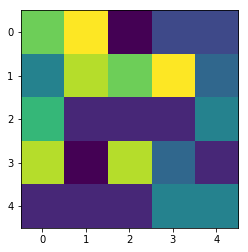

In [6]:
only_averages = False
prt = True
N, no_cols = 5, 10
gamma = 1    # strength of preference for low no. of cols
J = .2        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha)

## Full simulation

In [7]:
def init_edge_prob (J):
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    return edge_prob
    
def init_site_prob (alpha, no_cols):
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    return site_prob

def init_lambda_prob (gamma, no_cols):
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    return lambda_prob

In [57]:
def experiment_full_interaction (N, no_cols, gamma=0, J=0, alpha=0, gammas=None, Js=None, alphas=None):
    '''Run simulation for different parameters given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Identify varying parameter'''
    curr_params = {}
    curr_params['gamma'], curr_params['J'], curr_params['alpha'] = gamma, J, alpha
    params = None
    param_name = "None"
    for pms,pname in [(gammas,"Gamma"), (Js,"J"), (alphas,"Alpha")]:
        if pms is not None:
            params = pms
            param_name = pname
    nparam = len(params)
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = init_edge_prob(J)
    site_prob = init_site_prob(alpha, no_cols)   
    lambda_prob = init_lambda_prob(gamma, no_cols)
    print('edge probabilities:', edge_prob)
    print('site probabilities:', site_prob)
    print('lambda probabilities:', lambda_prob)
    
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.full(nparam, 1, dtype='float'), np.full(nparam, N*N, dtype='float')
    std_c, std_s_c = np.zeros(nparam), np.zeros(nparam)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter across the logspace'''
    print('Trying params:', params)
    converge_cnt = 0
    for iparam in range(nparam):
        
        '''Probabilities for the varying parameter'''
        param = params[iparam]
        print(iparam, ' - param:', param)
        if param_name=="Gamma":
            curr_params['gamma'] = param
            lambda_prob = init_lambda_prob(param, no_cols)
            print('lambda probabilities:', lambda_prob)
        elif param_name=="Alpha":
            curr_params['alpha'] = param
            site_prob = init_site_prob(param, no_cols)
            print('site probabilities:', site_prob)
        elif param_name=="J":
            curr_params['J'] = param
            edge_prob = init_edge_prob(param)
            print('edge probabilities:', edge_prob)
            
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
        print('Final configuration:')
        print(config)
        avg_c[iparam] = tot_c / (mc_steps)
        avg_s_c[iparam] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[iparam], avg_s_c[iparam])
        std_c[iparam] = np.std(no_cols_arr)
        std_s_c[iparam] = np.std(no_sites_arr)
        print('Final stds:', std_c[iparam], std_s_c[iparam])
        print('-'*120 + '\n')
        
        if (avg_c[iparam]==1 and std_c[iparam]==0):
            converge_cnt += 1
            if converge_cnt == 2:
                break
        
#         df_config = pd.DataFrame(config)
#         df_config.to_csv("Simulation_all_interaction_data/final_config_("
#                     + str(N)+ "," + str(no_cols)
#                     + ")_J_" + str(J) + "_alpha_" + str(alpha) + "_gamma_" + str(gamma)
#                     + "_vary_" + param_name + "_" + str(param) +"_steps_" + str((eq_steps, mc_steps)) + ".csv")
    
    f = plt.figure(figsize=(18, 5)); # plot the calculated values 
    
    if param_name=="Gamma":
        my_max_gamma = gammas[-1]
        my_gammas = np.linspace(0, my_max_gamma, num=200)
        z = [np.e**(-my_gamma) for my_gamma in my_gammas]
        y = [E_cols(N*N,zz,C) for zz in z]
        yerr = [np.real(std_cols(N*N,zz,C)) for zz in z]
        plt.errorbar(my_gammas, y, yerr, marker='o', color='black', capsize=3)
    
    plt.errorbar(params, avg_c, std_c, linestyle='solid', capsize=3, marker='o', color='IndianRed')
    
    plt.title(str(N*N) + " total sites / " + str(no_cols) + " colors", fontsize=20)
    plt.xlabel(param_name, fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.savefig("Simulation_all_interaction/avg_std_("
                + str(N)+ "," + str(no_cols)
                + ")_J_" + str(J) + "_alpha_" + str(alpha) + "_gamma_" + str(gamma)
                + "_vary_" + param_name + "_steps_" + str((eq_steps, mc_steps)) + ".png", format="png")
    
    # plt.show()
    
    df = pd.DataFrame([params, avg_c, std_c, avg_s_c, std_s_c], index=['params', 'avg_c', 'std_c', 'avg_s_c', 'std_s_c']).T
    df.to_csv("Simulation_all_interaction_data/avg_std_("
                + str(N)+ "," + str(no_cols)
                + ")_J_" + str(J) + "_alpha_" + str(alpha) + "_gamma_" + str(gamma)
                + "_vary_" + param_name + "_steps_" + str((eq_steps, mc_steps)) + ".csv")
    
    
    
    print(df.head())
    
    return params, avg_c, std_c

In [58]:
def plot_multiple (N, no_cols, params, avg_c, std_c, params2, param_name, param_name2, save_opts=""):
    f = plt.figure(figsize=(18, 5)) 
    
    for i in range(len(params)):
        plt.errorbar(params[i], avg_c[i], std_c[i], linestyle='solid', capsize=3, marker='o',
                     label=(str(param_name2)+" = "+str(params2[i])) )

    plt.title(str(N*N) + " total sites / " + str(no_cols) + " colors", fontsize=20)
    plt.xlabel(param_name, fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.legend()
    plt.savefig("Simulation_all_interaction/avg_std_("
                + str(N)+ "," + str(no_cols) + ")"
                + "_vary_" + param_name
                + "_vary_" + param_name2 + "_steps_" + str((eq_steps, mc_steps)) + "_"
                + save_opts + ".png", format="png")

    plt.show()

## J and Gamma phase diagram

In [104]:
import matplotlib.cm as cm

def save_to_csv_multiple (N, no_cols, params, avg_c, std_c, params2, param_name, param_name2, save_opts=""):
    
    full_results = []
    f = plt.figure(figsize=(18, 5)) 
    for i in range(len(params2)):
        tmp = [[params[i][j], params2[i], avg_c[i][j], std_c[i][j]] for j in range(len(params[i]))]
        for t in tmp: full_results.append(t)
    full_results = np.array(full_results)
    df = pd.DataFrame(full_results, columns=[param_name, param_name2, "Avg. no. of colors", "Std."])
    df.to_csv("Simulation_all_interaction_data/avg_std_("
                + str(N)+ "," + str(no_cols) + ")"
                + "_vary_" + param_name
                + "_vary_" + param_name2 + "_steps_" + str((eq_steps, mc_steps)) + "_"
                + save_opts + ".csv")
    print(df)
    
def plot_phase (N, no_cols, params, avg_c, std_c, params2, param_name, param_name2, save_opts=""):
    df = pd.read_csv("Simulation_all_interaction_data/avg_std_("
                        + str(N)+ "," + str(no_cols) + ")"
                        + "_vary_" + param_name
                        + "_vary_" + param_name2 + "_steps_" + str((eq_steps, mc_steps)) + "_"
                        + save_opts + ".csv")
    # colors = [(100,100,int(x)) for x in np.linspace(0, 255, no_cols)]
    # print(colors)
    # df['colors'] = [colors[int(x)] for x in df['Avg. no. of colors']]
    df.plot.scatter(x=param_name2,
                    y=param_name,
                    c="Avg. no. of colors",
                    cmap="inferno",
                    title = str(N*N) + " total sites / " + str(no_cols) + " colors",
                    figsize = (8,8))
    plt.savefig("Simulation_all_interaction/phase_("
                + str(N)+ "," + str(no_cols) + ")"
                + "_vary_" + param_name
                + "_vary_" + param_name2 + "_steps_" + str((eq_steps, mc_steps)) + "_"
                + save_opts + ".png", format="png")
    plt.show()

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 11.0 avg. sites per col: 1.4545454545454546
101 num. cols: 10.376237623762377 avg. sites per col: 1.5653749990383639
201 num. cols: 10.348258706467663 avg. sites per col: 1.5662310050369745
301 num. cols: 10.395348837209303 avg. sites per col: 1.5593564058680327
401 num. cols: 10.379052369077307 avg. sites per col: 1.563793258556356
501 num. cols: 10.359281437125748 avg. sites

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 2.2857142857142856
101 num. cols: 9.099009900990099 avg. sites per col: 1.7986598659865976
201 num. cols: 8.81592039800995 avg. sites per col: 1.8843904575247867
301 num. cols: 8.83388704318937 avg. sites per col: 1.8703158782893041
401 num. cols: 8.82294264339152 avg. sites per col: 1.8697657011871578
501 num. cols: 8.842315369261478 avg. sites per col: 1.8637084361635394
601 num. cols: 8.888519134775374 avg. sites per col: 1.8520394007914929
701 num. cols: 8.930099857346647 avg. sites per col: 1.840725513193424
801 num. cols: 8.86267166042447 avg. sites per col: 1.8566264918324895
901 num. cols: 8.873473917869035 avg. sites per col: 1.8553252395649777
1001 num. cols: 8.855144855144855 avg. sites per col: 1.8587520593514637
Final configuration:
[[ 5 12  4  4]
 [ 6  6  6  4]
 [15 16 10 13]
 [15  6 10  9]]
Final averages: 8.855

601 num. cols: 2.0632279534109816 avg. sites per col: 10.2473655019412
701 num. cols: 2.1654778887303854 avg. sites per col: 9.770423204945297
801 num. cols: 2.1373283395755305 avg. sites per col: 9.840699126092362
901 num. cols: 2.0455049944506105 avg. sites per col: 10.278653348131689
1001 num. cols: 2.03996003996004 avg. sites per col: 10.292374292374294
Final configuration:
[[4 4 4 4]
 [4 4 4 4]
 [4 4 4 4]
 [4 4 4 4]]
Final averages: 2.035820895522388 10.3150912106136
Final stds: 1.0966754136691774 4.952635695988084
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 2.3069306930693068 avg. sites per col: 9.269966996699678
201 num. cols: 2.3184079601990

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0 avg. sites per col: 16.0
301 num. cols: 1.0 avg. sites per col: 16.0
401 num. cols: 1.0 avg. sites per col: 16.0
501 num. cols: 1.0 avg. sites per col: 16.0
601 num. cols: 1.0 avg. sites per col: 16.0
701 num. cols: 1.0 avg. sites per col: 16.0
801 num. cols: 1.0 avg. sites per col: 16.0
901 num. cols: 1.0 avg. sites per col: 16.0
1001 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[15 15 15 15]
 [15 15 15 15]
 [15 15 15 15]
 [15 15 15 15]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

20  - param: 2.0
edge probabilities: [0.98168436 0.01831564]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibrat

601 num. cols: 8.009983361064892 avg. sites per col: 2.047632013023039
701 num. cols: 8.024251069900142 avg. sites per col: 2.046978857249907
801 num. cols: 8.079900124843945 avg. sites per col: 2.0307069265870825
901 num. cols: 8.061043285238624 avg. sites per col: 2.033895959756119
1001 num. cols: 8.074925074925074 avg. sites per col: 2.029502964567903
Final configuration:
[[ 5 13 11 15]
 [ 1 13  5 11]
 [ 4  1 11  4]
 [ 1 13  8  4]]
Final averages: 8.070646766169155 2.030522711119729
Final stds: 1.2192421100778363 0.32589115462728485
------------------------------------------------------------------------------------------------------------------------

4  - param: 0.4
edge probabilities: [0.55067104 0.44932896]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 1.7777777777777777
101 num. cols: 8.386138613861386 avg. sites per col: 1.9543725801151526
2

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 1.8514851485148516 avg. sites per col: 10.085808580858087
201 num. cols: 1.5970149253731343 avg. sites per col: 11.966832504145946
301 num. cols: 1.8073089700996678 avg. sites per col: 11.060908084163922
401 num. cols: 1.7780548628428927 avg. sites per col: 11.428761429758943
501 num. cols: 1.910179640718563 avg. sites per col: 10.810379241516953
601 num. cols: 1.9883527454242929 avg. sites per col: 10.540654464780905
701 num. cols: 2.182596291012839 avg. sites per col: 9.888594524828457
801 num. cols: 2.2659176029962547 avg. sites per col: 9.47470423874915
901 num. cols: 2.1453940066592674 avg. sites per col: 10.03910998361606
1001 num. cols: 2.1708291708291707 avg. sites per col: 10.010427667570507
Final configuration:
[[ 6  6  6  6]
 [12 12  6  6]
 [12 12 16 16]
 [16 16 16 16]]
Final averages: 2.174129353

1001 num. cols: 1.013986013986014 avg. sites per col: 15.888111888111888
Final configuration:
[[4 4 4 4]
 [4 4 4 4]
 [4 4 4 4]
 [4 4 4 4]]
Final averages: 1.0139303482587065 15.888557213930348
Final stds: 0.11720193537692808 0.9376154830154246
------------------------------------------------------------------------------------------------------------------------

17  - param: 1.7
edge probabilities: [0.96662673 0.03337327]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0199004975124377 avg. sites per col: 15.840796019900498
301 num. cols: 1.0132890365448506 avg. sites per col: 15.893687707641195
401 num. cols: 1.0099750623441397 avg. sites per col: 15.920199501246882
501 num. cols: 1.0079840319361277 avg. sites per col: 15.936127744510978
601 num. cols: 1.0066555740432612 avg. sites per

equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 1.7777777777777777
101 num. cols: 7.099009900990099 avg. sites per col: 2.3300330033003283
201 num. cols: 6.63681592039801 avg. sites per col: 2.5025349443259897
301 num. cols: 6.664451827242525 avg. sites per col: 2.4759795391024704
401 num. cols: 6.596009975062344 avg. sites per col: 2.507920674504228
501 num. cols: 6.644710578842315 avg. sites per col: 2.480448626556419
601 num. cols: 6.64559068219634 avg. sites per col: 2.475112907059674
701 num. cols: 6.804564907275321 avg. sites per col: 2.4207322872087587
801 num. cols: 6.967540574282148 avg. sites per col: 2.3685948120405147
901 num. cols: 6.916759156492786 avg. sites per col: 2.38828814544686
1001 num. cols: 6.874125874125874 avg. sites per col: 2.400945086659364
Final configuration:
[[ 2  2 12 14]
 [ 9  9  9  5]
 [ 2  2 12  5]
 [ 4  4  2  2]]
Final averages: 6.870646766169155 2.4020026849877505
Final stds: 1.1916726

701 num. cols: 2.2667617689015693 avg. sites per col: 9.45164051355203
801 num. cols: 2.2946317103620473 avg. sites per col: 9.36662505201827
901 num. cols: 2.2852386237513875 avg. sites per col: 9.325934147243764
1001 num. cols: 2.311688311688312 avg. sites per col: 9.104229104229088
Final configuration:
[[4 4 4 4]
 [4 4 4 4]
 [4 4 4 4]
 [4 4 4 4]]
Final averages: 2.3064676616915425 9.131674958540614
Final stds: 1.168239718550525 4.803722703312893
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 2.099009900990099 avg. sites per col: 10.46864686468647
201 num. cols: 2.3034825870646767 avg. sites per col: 8.82918739635156
301 num. cols: 2.0498338870431896 a

equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.2277227722772277 avg. sites per col: 14.178217821782178
201 num. cols: 1.1144278606965174 avg. sites per col: 15.08457711442786
301 num. cols: 1.0863787375415281 avg. sites per col: 15.308970099667775
401 num. cols: 1.0648379052369077 avg. sites per col: 15.481296758104738
501 num. cols: 1.0518962075848304 avg. sites per col: 15.584830339321357
601 num. cols: 1.0582362728785357 avg. sites per col: 15.542983915696063
701 num. cols: 1.0499286733238231 avg. sites per col: 15.608178792201617
801 num. cols: 1.0436953807740326 avg. sites per col: 15.657095297544737
901 num. cols: 1.0388457269700333 avg. sites per col: 15.695153533111359
1001 num. cols: 1.034965034965035 avg. sites per col: 15.725607725607727
Final configuration:
[[11 11 11 11]
 [11 11 11 11]
 [11 11 11 11]
 [11 11 11 11]]
Final averages: 1.0348258706467661 15.726699834162522
Final stds: 0.1886

lambda probabilities: [9.50212932e-01 4.73083162e-02 2.35534237e-03 1.17265592e-04
 5.83831003e-06 2.90672341e-07 1.44717237e-08 7.20504697e-10
 3.58718166e-11 1.78595259e-12 8.89173435e-14 4.42693386e-15
 2.20404059e-16 1.09732719e-17 5.46327041e-19 2.86251858e-20]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 2.2857142857142856
101 num. cols: 5.920792079207921 avg. sites per col: 2.7539839698255504
201 num. cols: 5.845771144278607 avg. sites per col: 2.7859748874674213
301 num. cols: 6.205980066445183 avg. sites per col: 2.638443284290462
401 num. cols: 6.341645885286783 avg. sites per col: 2.598662074971309
501 num. cols: 6.479041916167665 avg. sites per col: 2.53752811

equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 3.2
101 num. cols: 4.267326732673268 avg. sites per col: 3.878547854785476
201 num. cols: 3.054726368159204 avg. sites per col: 7.003648424543943
301 num. cols: 2.637873754152824 avg. sites per col: 8.380066445182736
401 num. cols: 2.628428927680798 avg. sites per col: 7.889609310058219
501 num. cols: 2.656686626746507 avg. sites per col: 7.823819028609475
601 num. cols: 2.8402662229617306 avg. sites per col: 7.261231281198
701 num. cols: 2.7203994293865907 avg. sites per col: 7.849738468854009
801 num. cols: 2.6154806491885143 avg. sites per col: 8.231377444860575
901 num. cols: 2.637069922308546 avg. sites per col: 8.175508694043629
1001 num. cols: 2.5594405594405596 avg. sites per col: 8.371095571095543
Final configuration:
[[15 15 15 15]
 [15 15 15 15]
 [15 15 15 15]
 [15 15 15 15]]
Final averages: 2.553233830845771 8.40145936981755
Final stds: 1.286130371845264 4.747255594676256
-----------------------------------------

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0 avg. sites per col: 16.0
301 num. cols: 1.0299003322259137 avg. sites per col: 15.76079734219269
401 num. cols: 1.027431421446384 avg. sites per col: 15.780548628428928
501 num. cols: 1.0219560878243512 avg. sites per col: 15.82435129740519
601 num. cols: 1.0183028286189684 avg. sites per col: 15.853577371048253
701 num. cols: 1.0156918687589158 avg. sites per col: 15.874465049928673
801 num. cols: 1.013732833957553 avg. sites per col: 15.890137328339575
901 num. cols: 1.0122086570477247 avg. sites per col: 15.902330743618203
1001 num. cols: 1.010989010989011 avg. sites per col: 15.912087912087912
Final configuration:
[[5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]]
Final averages: 1.0109452736318407 15.912437810945274
Final stds: 0.1040455410719985 0.832364328575

501 num. cols: 3.812375249500998 avg. sites per col: 4.464290466685677
601 num. cols: 3.698835274542429 avg. sites per col: 4.580049124475104
701 num. cols: 3.75320970042796 avg. sites per col: 4.489694993546651
801 num. cols: 3.8114856429463173 avg. sites per col: 4.413578265263671
901 num. cols: 3.8734739178690343 avg. sites per col: 4.334823740817085
1001 num. cols: 3.955044955044955 avg. sites per col: 4.249693163978872
Final configuration:
[[ 8  8  9  1]
 [13  8  9  9]
 [ 8  8 13  1]
 [ 9  8  8  1]]
Final averages: 3.955223880597015 4.248699360341145
Final stds: 0.8469935561772808 1.0136814373356586
------------------------------------------------------------------------------------------------------------------------

4  - param: 0.4
edge probabilities: [0.55067104 0.44932896]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 6.0 avg. sites per col: 2.6666666666666665
101

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0495049504950495 avg. sites per col: 15.603960396039604
201 num. cols: 1.1044776119402986 avg. sites per col: 15.164179104477611
301 num. cols: 1.069767441860465 avg. sites per col: 15.44186046511628
401 num. cols: 1.0523690773067331 avg. sites per col: 15.581047381546135
501 num. cols: 1.089820359281437 avg. sites per col: 15.281437125748504
601 num. cols: 1.0748752079866888 avg. sites per col: 15.40099833610649
701 num. cols: 1.0641940085592012 avg. sites per col: 15.48644793152639
801 num. cols: 1.0561797752808988 avg. sites per col: 15.55056179775281
901 num. cols: 1.0499445061043284 avg. sites per col: 15.600443951165373
1001 num. cols: 1.0449550449550449 avg. sites per col: 15.640359640359641
Final configuration:
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
Final averages: 1.04477611

501 num. cols: 3.06187624750499 avg. sites per col: 5.25083166999336
601 num. cols: 3.0515806988352745 avg. sites per col: 5.26455906821967
701 num. cols: 3.044222539229672 avg. sites per col: 5.274369947693824
801 num. cols: 3.0387016229712858 avg. sites per col: 5.281731169371669
901 num. cols: 3.034406215316315 avg. sites per col: 5.287458379578258
1001 num. cols: 3.030969030969031 avg. sites per col: 5.292041292041271
Final configuration:
[[11  4 11 11]
 [ 4  9  9  9]
 [ 9 11 11  9]
 [11 11  4 11]]
Final averages: 3.0308457711442784 5.2922056384742735
Final stds: 0.172899709504653 0.23053294600620397
------------------------------------------------------------------------------------------------------------------------

3  - param: 0.3
edge probabilities: [0.45118836 0.54881164]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 2.6

901 num. cols: 1.0 avg. sites per col: 16.0
1001 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[11 11 11 11]
 [11 11 11 11]
 [11 11 11 11]
 [11 11 11 11]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

   params     avg_c     std_c    avg_s_c   std_s_c
0     0.0  3.692537  0.760985   4.503615  0.840817
1     0.1  4.268657  0.554908   3.809751  0.483910
2     0.2  3.030846  0.172900   5.292206  0.230533
3     0.3  2.591045  0.491641   6.423881  1.311043
4     0.4  1.295522  0.671547  14.283250  3.773556
GAMMA: 8 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [9.99664537e-01 3.35350093e-04 1.12497423e-07 3.77386813e-11
 1.26599172e-14 4.24692909e-18 1.42468599e-21 4.77928907e-25
 1.6

0  - param: 0.0
edge probabilities: [0. 1.]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 2.0 avg. sites per col: 8.0
201 num. cols: 2.0 avg. sites per col: 8.0
301 num. cols: 2.0 avg. sites per col: 8.0
401 num. cols: 2.0 avg. sites per col: 8.0
501 num. cols: 2.0 avg. sites per col: 8.0
601 num. cols: 2.0 avg. sites per col: 8.0
701 num. cols: 2.0 avg. sites per col: 8.0
801 num. cols: 2.0 avg. sites per col: 8.0
901 num. cols: 2.0 avg. sites per col: 8.0
1001 num. cols: 2.0 avg. sites per col: 8.0
Final configuration:
[[4 4 8 4]
 [8 8 8 4]
 [4 4 4 8]
 [4 4 8 4]]
Final averages: 2.0 8.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
equilibration step: 0
equilibration step: 100

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0 avg. sites per col: 16.0
301 num. cols: 1.0 avg. sites per col: 16.0
401 num. cols: 1.0 avg. sites per col: 16.0
501 num. cols: 1.0 avg. sites per col: 16.0
601 num. cols: 1.0 avg. sites per col: 16.0
701 num. cols: 1.0 avg. sites per col: 16.0
801 num. cols: 1.0 avg. sites per col: 16.0
901 num. cols: 1.0 avg. sites per col: 16.0
1001 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[9 9 9 9]
 [9 9 9 9]
 [9 9 9 9]
 [9 9 9 9]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

   params  avg_c  std_c  avg_s_c  std_s_c
0     0.0    2.0    0.0      8.0      0.0
1     0.1    1.0    0.0     16.0      0.0
2     0.2    2.0    0.0      8.0 

<Figure size 1296x360 with 0 Axes>

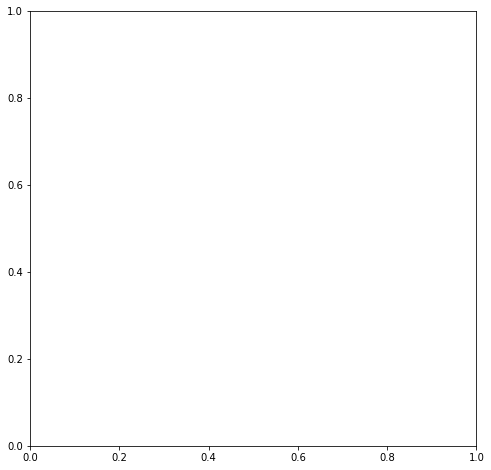

<Figure size 1296x360 with 0 Axes>

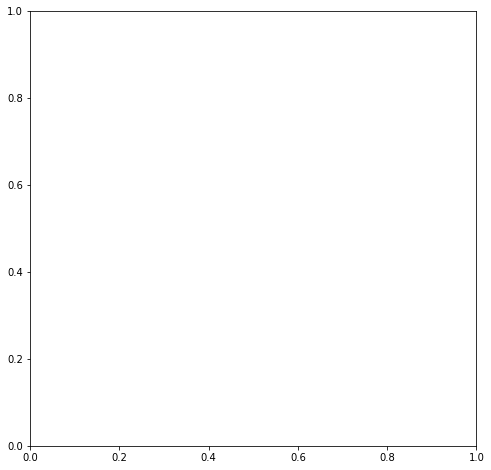

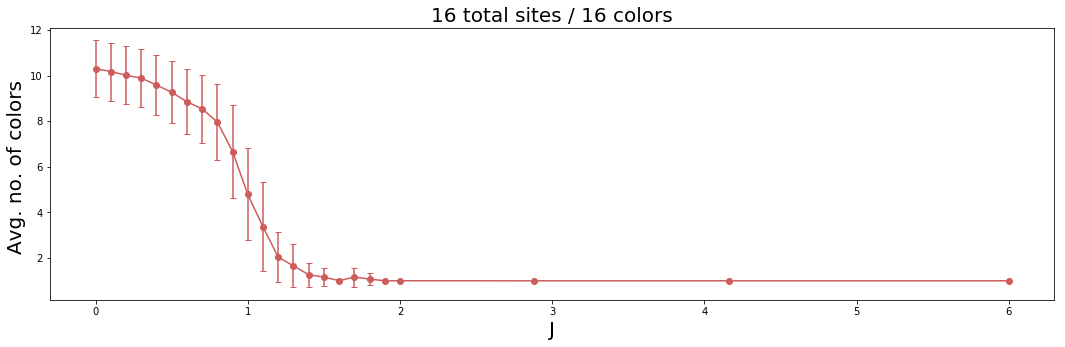

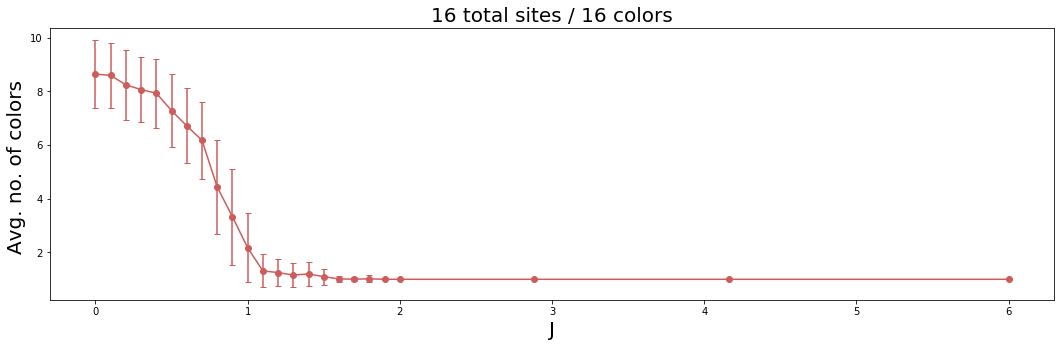

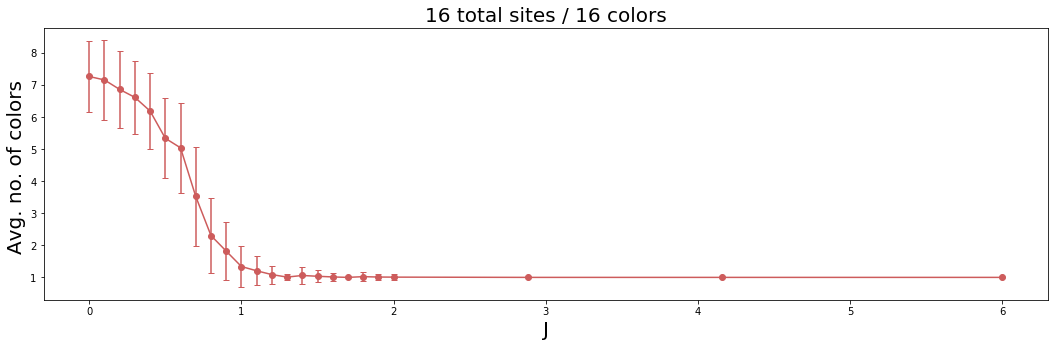

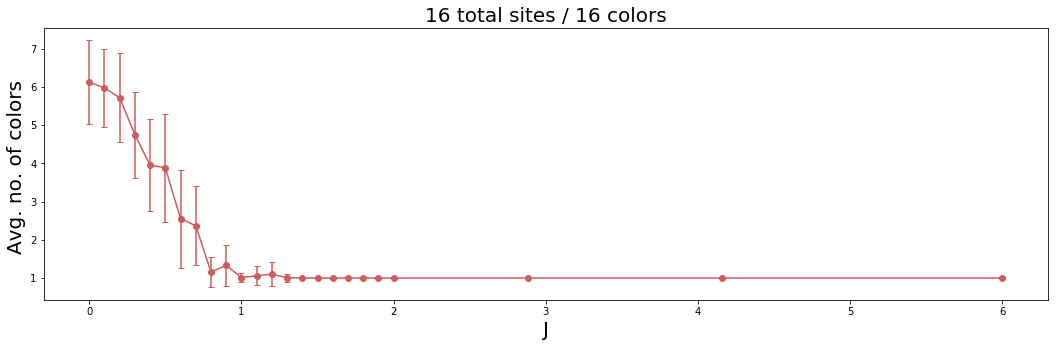

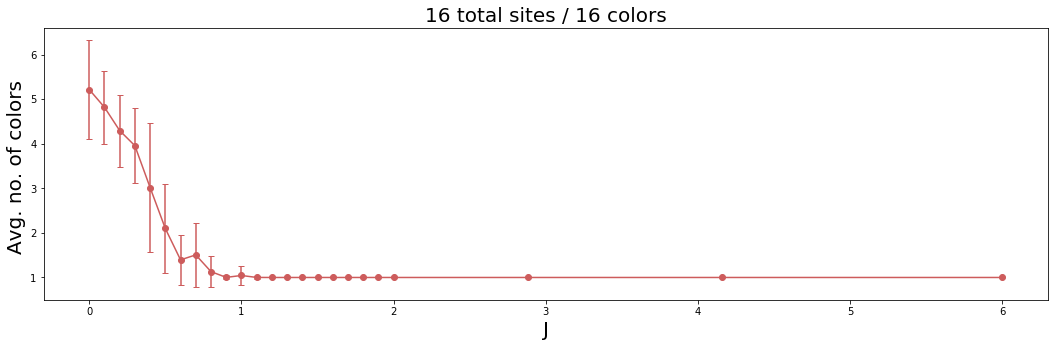

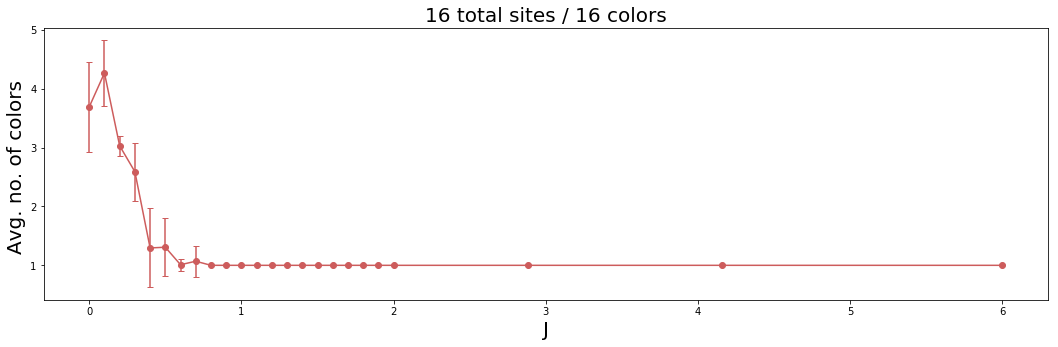

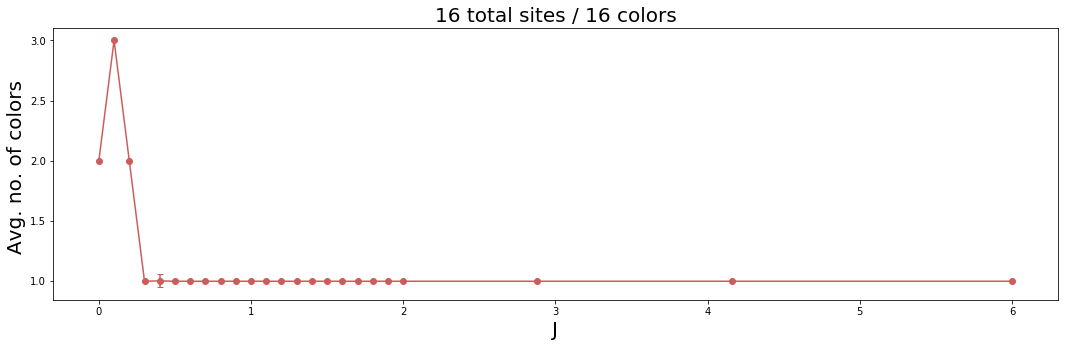

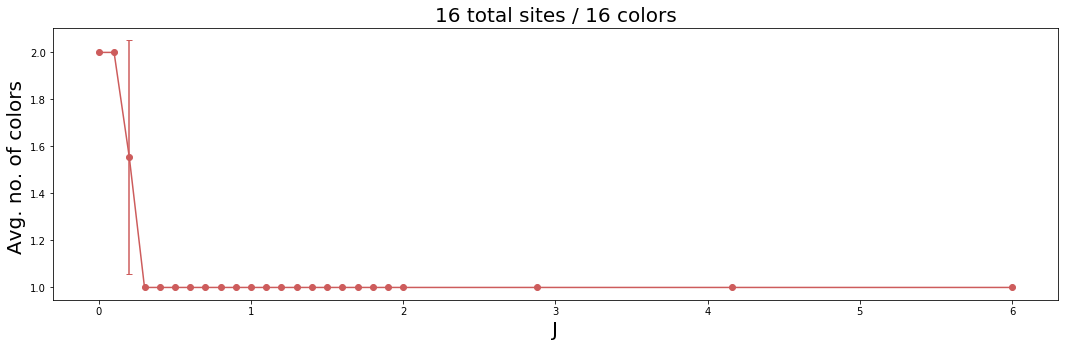

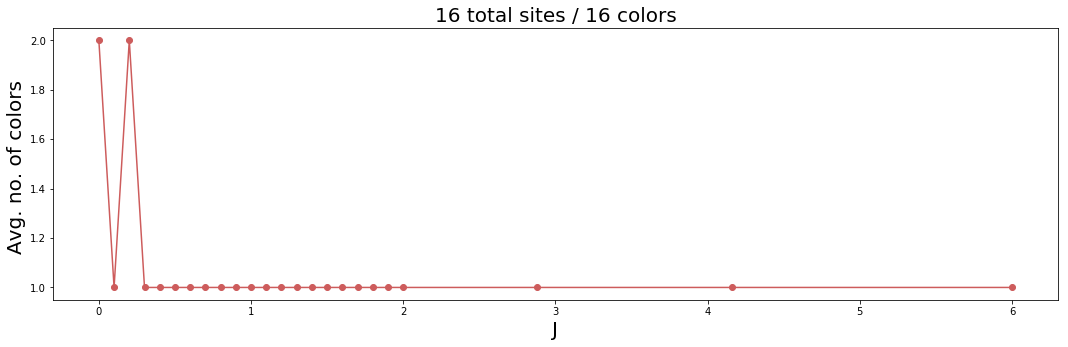

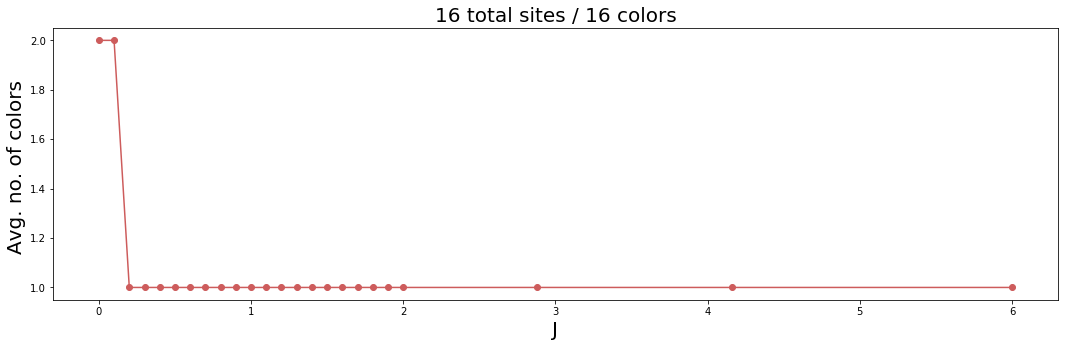

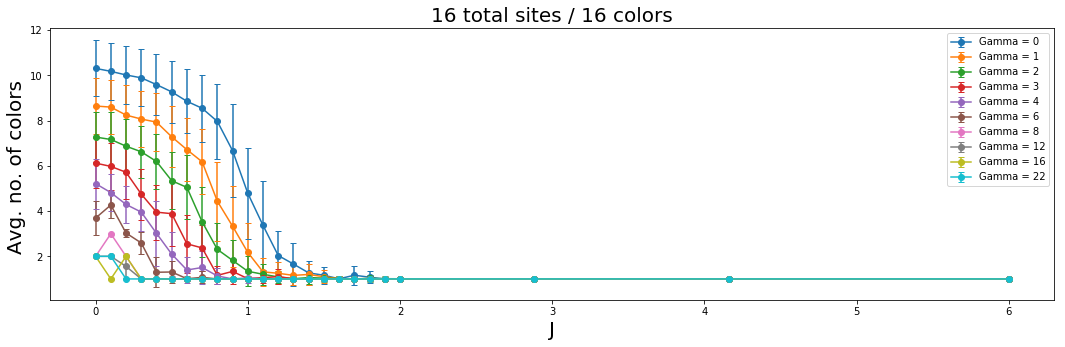

[(100, 100, 0.0), (100, 100, 17.0), (100, 100, 34.0), (100, 100, 51.0), (100, 100, 68.0), (100, 100, 85.0), (100, 100, 102.0), (100, 100, 119.0), (100, 100, 136.0), (100, 100, 153.0), (100, 100, 170.0), (100, 100, 187.0), (100, 100, 204.0), (100, 100, 221.0), (100, 100, 238.0), (100, 100, 255.0)]
        J  Gamma      avg_c  Avg. no. of colors            colors
0    0.00    0.0  10.311443            1.239290  (100, 100, 17.0)
1    0.10    0.0  10.180100            1.269780  (100, 100, 17.0)
2    0.20    0.0  10.019900            1.267898  (100, 100, 17.0)
3    0.30    0.0   9.893532            1.264757  (100, 100, 17.0)
4    0.40    0.0   9.593035            1.333290  (100, 100, 17.0)
5    0.50    0.0   9.272637            1.361627  (100, 100, 17.0)
6    0.60    0.0   8.855721            1.421260  (100, 100, 17.0)
7    0.70    0.0   8.547264            1.491937  (100, 100, 17.0)
8    0.80    0.0   7.965174            1.652913  (100, 100, 17.0)
9    0.90    0.0   6.672637            2.0

AttributeError: 'list' object has no attribute 'shape'

In [100]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 4

params, avg_c, std_c = [], [], []
gammas = [0,1,2,3,4,6,8,12,16,22]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")
plot_phase (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
equilibration step: 0
1 num. cols: 11.0 avg. sites per col: 1.4545454545454546
Final configuration:
[[15  6 14  7]
 [10 16  3 13]
 [ 9  9  4  5]
 [16 15  1 16]]
Final averages: 10.4 1.5594923594923593
Final stds: 1.2 0.18472040827072772
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
equilibration step: 0
1 num. cols: 9.0 avg. sites per col: 1.7777777777777777
Final configuration:
[[ 8  8 14  7]
 [ 5 1

1 num. cols: 8.0 avg. sites per col: 2.0
Final configuration:
[[ 3 16  3 16]
 [16 14  5 12]
 [12 14  8  1]
 [ 8 16  9  6]]
Final averages: 9.533333333333333 1.6880808080808083
Final stds: 0.7180219742846006 0.13023394927091672
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
equilibration step: 0
1 num. cols: 9.0 avg. sites per col: 1.7777777777777777
Final configuration:
[[13  1  2 13]
 [ 5 16 13 13]
 [ 2 16  3  5]
 [10 15 16 16]]
Final averages: 8.0 2.033477633477633
Final stds: 1.0954451150103321 0.24747436884434154
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.2
edge probabilities: [0.32967995 0.67032005]
equilibration step: 0
1 num. cols: 7.0 avg. sites per col: 2.2857142857142856
Final configuration:
[[ 4  8  8  7]
 [14  5 11  8]
 [ 3  7 11  3]
 [15 15  4 16]]


1 num. cols: 7.0 avg. sites per col: 2.2857142857142856
Final configuration:
[[ 5  5  1 15]
 [ 8 15 15 13]
 [ 1  1 13 13]
 [12  6  6  6]]
Final averages: 6.733333333333333 2.4000000000000004
Final stds: 0.6798692684790381 0.23637473611411156
------------------------------------------------------------------------------------------------------------------------

6  - param: 0.6
edge probabilities: [0.69880579 0.30119421]
equilibration step: 0
1 num. cols: 2.0 avg. sites per col: 8.0
Final configuration:
[[10 10  2 13]
 [ 2 13 13  6]
 [ 2  3 13 13]
 [10 13 13 13]]
Final averages: 2.933333333333333 6.364444444444445
Final stds: 1.2892719737209144 2.101691264872057
------------------------------------------------------------------------------------------------------------------------

7  - param: 0.7
edge probabilities: [0.75340304 0.24659696]
equilibration step: 0
1 num. cols: 4.0 avg. sites per col: 4.0
Final configuration:
[[ 7  7  7  1]
 [ 7  7  7  7]
 [ 7  7  7  7]
 [ 7 13  7  7]]
Fin

1 num. cols: 2.0 avg. sites per col: 8.0
Final configuration:
[[1 1 1 5]
 [1 1 5 5]
 [1 1 5 5]
 [1 1 1 1]]
Final averages: 2.0 8.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[15 15 15 15]
 [15 15 15 15]
 [15 15 15 15]
 [15 15 15 15]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[6 6 6 6]
 [6 6 6 6]
 [6 6 6 6]
 [6 6 6 6]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
-----------------------------------------------------------------------------------------------------------------------

1 num. cols: 6.0 avg. sites per col: 2.6666666666666665
Final configuration:
[[ 9  4  1 16]
 [ 9  6  9 15]
 [ 1  4  9 15]
 [ 1  9 15  4]]
Final averages: 6.0 2.666666666666666
Final stds: 0.0 4.440892098500626e-16
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.2
edge probabilities: [0.32967995 0.67032005]
equilibration step: 0
1 num. cols: 6.0 avg. sites per col: 2.6666666666666665
Final configuration:
[[10  4  2 15]
 [10  2  4 15]
 [ 4  2  1  7]
 [10 15 10 15]]
Final averages: 6.0 2.666666666666666
Final stds: 0.0 4.440892098500626e-16
------------------------------------------------------------------------------------------------------------------------

3  - param: 0.3
edge probabilities: [0.45118836 0.54881164]
equilibration step: 0
1 num. cols: 4.0 avg. sites per col: 4.0
Final configuration:
[[ 3  2  3  2]
 [ 2  2  2  2]
 [13 13  6  2]
 [13 13  3  2]]
Final averages: 4.0 4.0
Final stds: 0.0 0

1 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

   params     avg_c     std_c   avg_s_c       std_s_c
0     0.0  5.000000  0.000000  3.200000  8.881784e-16
1     0.1  5.000000  0.000000  3.200000  8.881784e-16
2     0.2  4.000000  0.000000  4.000000  0.000000e+00
3     0.3  5.000000  0.000000  3.200000  8.881784e-16
4     0.4  5.133333  0.339935  3.128889  1.812985e-01
GAMMA: 12 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [9.99993856e-01 6.14417460e-06 3.77511135e-11 2.31950858e-16
 1.42515533e-21 8.75645696e-27 5.38015310e-32 3.30568032e-37
 2.03108018e-42 1.24793880e-47 7.66760096e-53 4.

1 num. cols: 2.0 avg. sites per col: 8.0
Final configuration:
[[4 4 4 4]
 [4 4 4 4]
 [4 4 9 4]
 [4 4 4 4]]
Final averages: 2.0 8.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
equilibration step: 0
1 num. cols: 3.0 avg. sites per col: 5.333333333333333
Final configuration:
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
Final averages: 1.9333333333333333 10.666666666666666
Final stds: 0.9285592184789412 5.059644256269407
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]
equilibration step: 0
1 num. cols: 2.0 avg. sites per col: 8.0
Final configuration:
[[4 4 4 4]
 [4 4 4 9]
 [4 4 4 4]
 [4 4 4 4]]
Final averages: 2.0 8.0
Final stds: 0.0 0.0
------------------------------------------------------------------

<Figure size 1296x360 with 0 Axes>

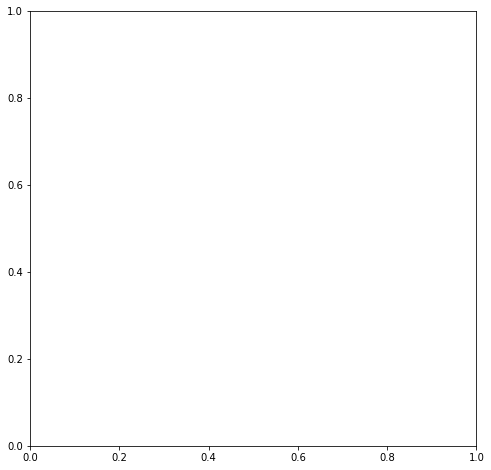

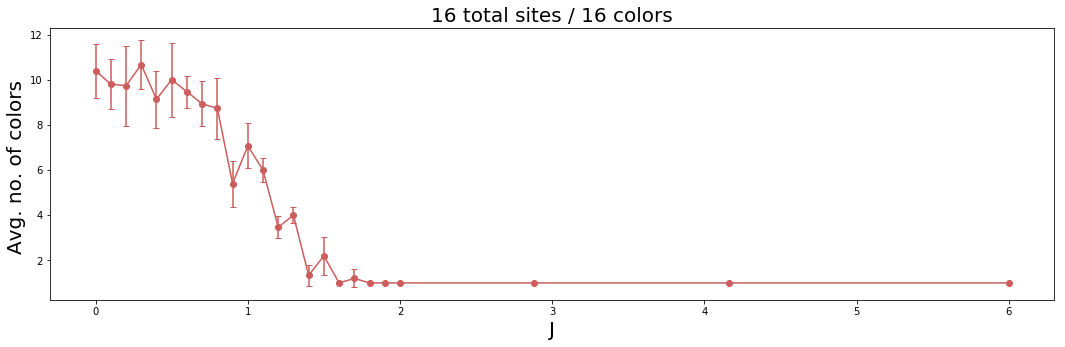

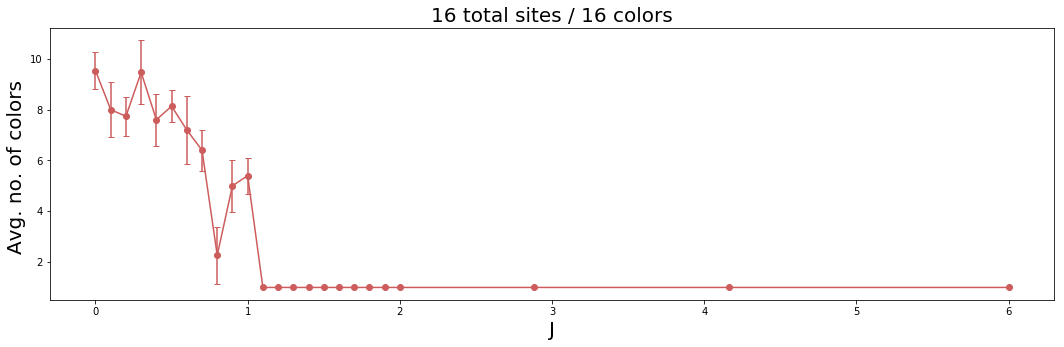

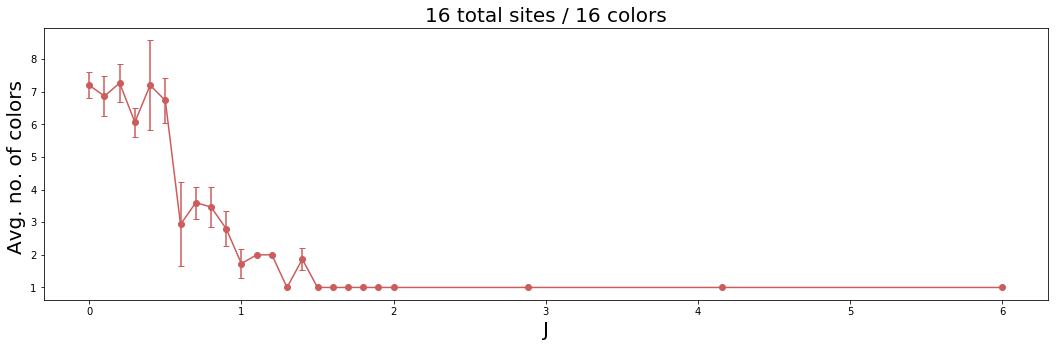

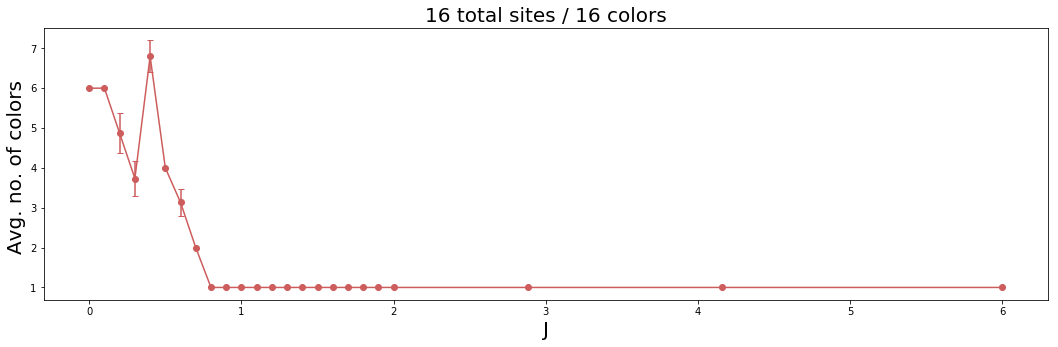

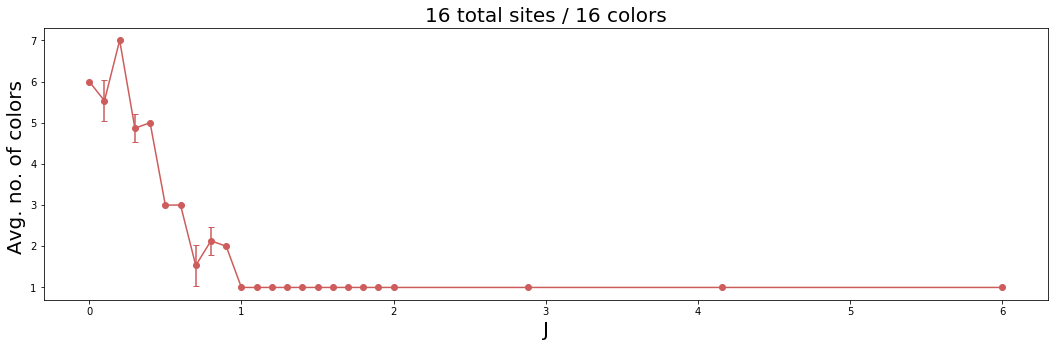

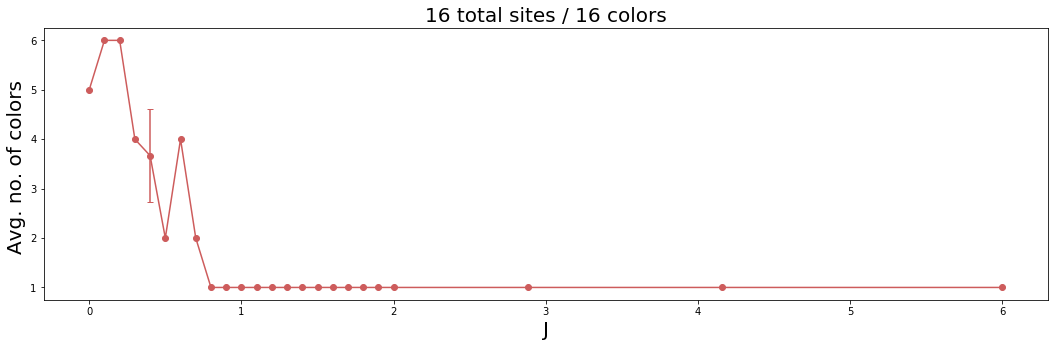

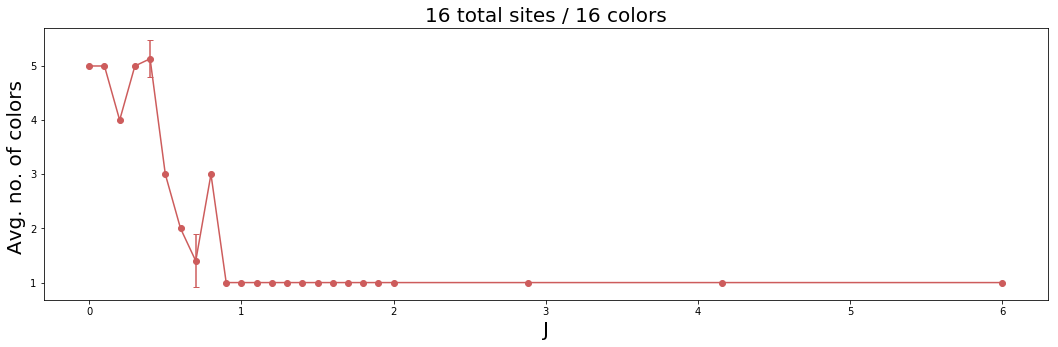

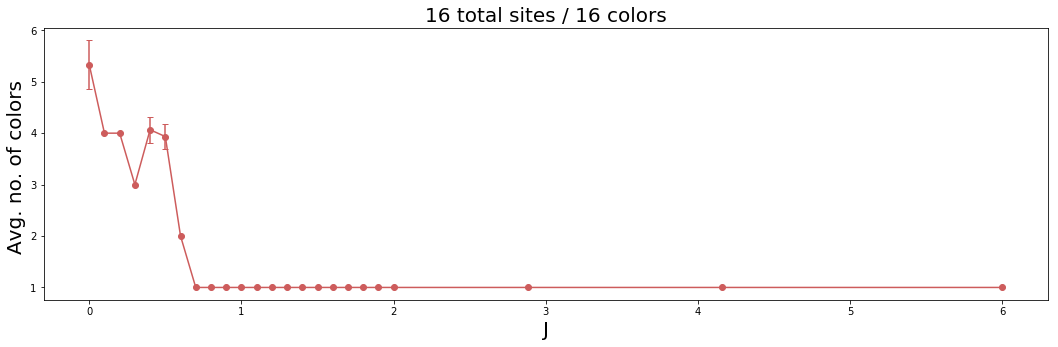

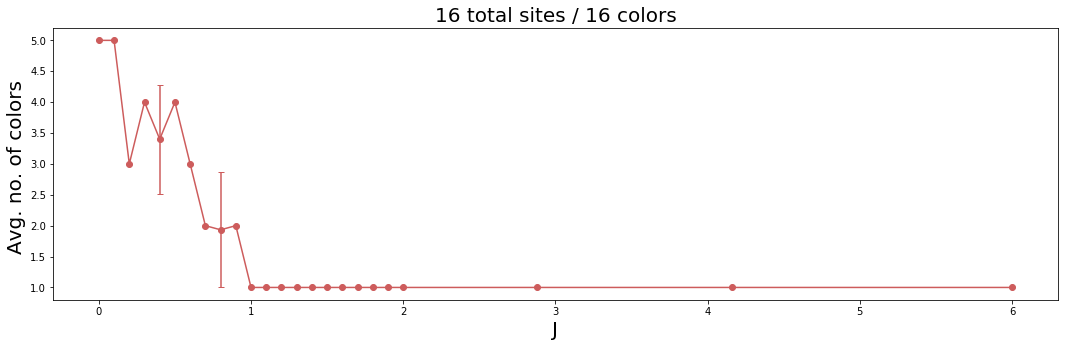

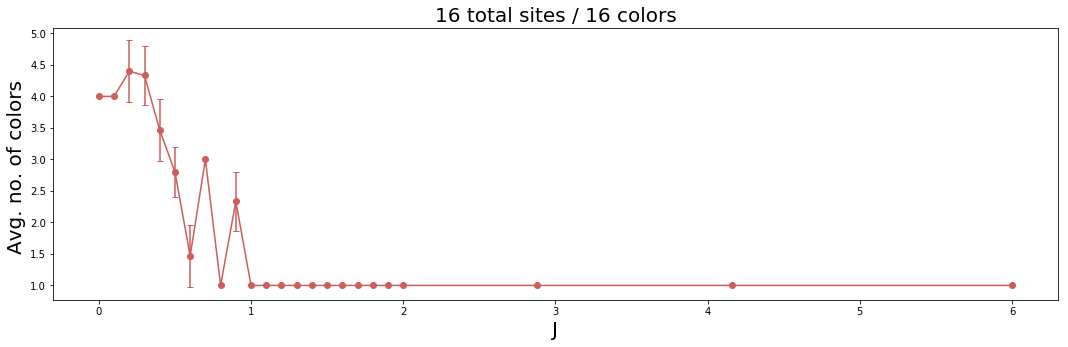

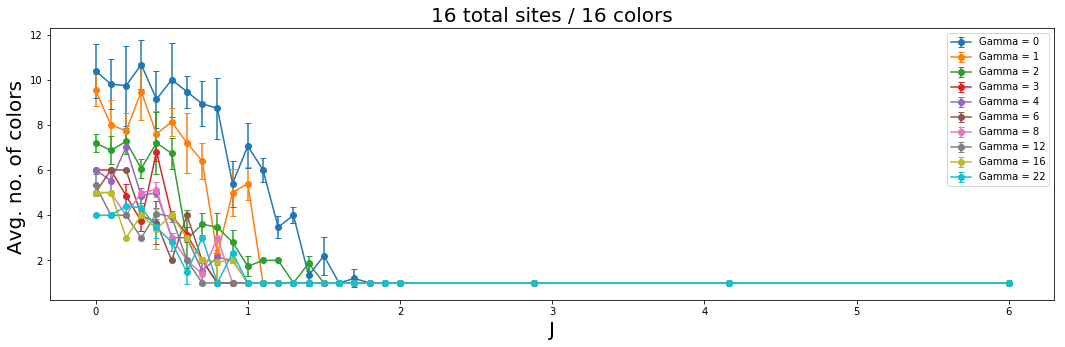

        J  Gamma  Avg. no. of colors      Std.
0    0.00    0.0           10.400000  1.200000
1    0.10    0.0            9.800000  1.107550
2    0.20    0.0            9.733333  1.768867
3    0.30    0.0           10.666667  1.074968
4    0.40    0.0            9.133333  1.257864
5    0.50    0.0           10.000000  1.632993
6    0.60    0.0            9.466667  0.718022
7    0.70    0.0            8.933333  0.997775
8    0.80    0.0            8.733333  1.339983
9    0.90    0.0            5.400000  1.019804
10   1.00    0.0            7.066667  0.997775
11   1.10    0.0            6.000000  0.516398
12   1.20    0.0            3.466667  0.498888
13   1.30    0.0            4.000000  0.365148
14   1.40    0.0            1.333333  0.471405
15   1.50    0.0            2.200000  0.832666
16   1.60    0.0            1.000000  0.000000
17   1.70    0.0            1.200000  0.400000
18   1.80    0.0            1.000000  0.000000
19   1.90    0.0            1.000000  0.000000
20   2.00    

<Figure size 1296x360 with 0 Axes>

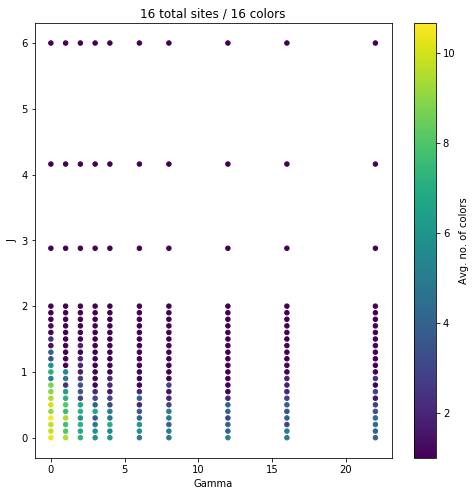

In [103]:
eq_steps = 55          #  number of MC sweeps for equilibration
mc_steps = 15          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 4

params, avg_c, std_c = [], [], []
gammas = [0,1,2,3,4,6,8,12,16,22]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")
save_to_csv_multiple (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")
plot_phase (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")